In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [69]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
import numpy as np
from sklearn.decomposition import PCA

# Lectura y transformación de datos

In [3]:
datos = pd.read_excel("datos/Export.xlsx", skiprows=7)
datos.head(5)

,Num,Country,Company,Total operating revenue,Operational Status,City,Business Description/Products,Industry (NAICS),Main Activities (NAICS),Secondary Activities (NAICS),...,% Change from 3 Year Low,% Change from 5 Year Low,Fiscal Year,Audited,Consolidated,Source,EMIS ID,CO-NIT,ISIN,Ticker Symbol
0,1,Colombia,Ecopetrol S.A.,1.427485e+08,Operational,Bogota D.C.,Ecopetrol S.A. was founded in 1948 and is the ...,Natural Gas Extraction(21113); Crude Petroleum...,Natural Gas Extraction(21113); Crude Petroleum...,NaN,...,-0.4,-0.42,2023.0,Audited,Consolidated,Superfinanciera – IFRS,1192567.0,899999068,"COC04PA00016, US2791581091",ECOPETROL
1,2,Colombia,Organizacion Terpel S.A.,3.625272e+07,Operational,Bogota D.C.,Organizacion Terpel S.A. distributes and sells...,Petroleum and Petroleum Products Merchant Whol...,Petroleum and Petroleum Products Merchant Whol...,NaN,...,NaN,NaN,2023.0,Audited,Consolidated,Superfinanciera – IFRS,1208163.0,830095213,COG20PA00021,TERPEL
2,3,Colombia,D1 S A S,1.742413e+07,Operational,Bogota D.C.,"D1 S.A.S, with its brand of Tiendas D1, was cr...",Grocery Stores(4451),Grocery Stores(4451),NaN,...,NaN,NaN,2023.0,Audited,Individual,Superintendencia de Sociedades - IFRS Financia...,3524378.0,900276962,,
3,4,Colombia,Enel Colombia S.A. E.S.P.,1.672487e+07,Operational,Bogota D.C.,Emgesa S.A. ESP (formerly Central Hidroelectri...,Electric Power Generation(22111),Electric Power Generation(22111),NaN,...,NaN,NaN,2023.0,Audited,Consolidated,Superfinanciera – IFRS,1193219.0,860063875,,
4,5,Colombia,Drummond Ltd,1.542435e+07,Operational,Bogota D.C.,Drummond Ltd. is a subsidiary of the U.S compa...,Support Activities for Oil and Gas Operations(...,Support Activities for Oil and Gas Operations(...,NaN,...,NaN,NaN,2023.0,Audited,Individual,Superintendencia de Sociedades - IFRS Financia...,1192247.0,800021308,,


In [4]:
datos = datos[0:10000]
datos = datos.loc[:,("Company", "Property, plant and equipment", "Cash and Cash Equivalents", "Import", "Export", "Net Sales Revenue Trend (%)", "Operating Profit Trend (%)", "Industry (NAICS)")]

In [5]:
datos.columns

Index(['Company', 'Property, plant and equipment', 'Cash and Cash Equivalents',
       'Import', 'Export', 'Net Sales Revenue Trend (%)',
       'Operating Profit Trend (%)', 'Industry (NAICS)'],
      dtype='object')

In [6]:
datos.shape

(10000, 8)

In [7]:
datos.head()

,Company,"Property, plant and equipment",Cash and Cash Equivalents,Import,Export,Net Sales Revenue Trend (%),Operating Profit Trend (%),Industry (NAICS)
0,Ecopetrol S.A.,95171301.60,12336115.05,"UK (4.81%), Philippines, NL (4.66%), Austria, ...","AU (0.06%), NL (1.84%), MY (2.39%), BN (0.25%)...",-10.28,-30.69,Natural Gas Extraction(21113); Crude Petroleum...
1,Organizacion Terpel S.A.,3939357.24,916490.75,"Philippines, NL (0.04%), Belgium, KR (1.6%), C...","UK (0.04%), NL (47.11%), JM (0.17%), EC (3.59%...",2.17,10.06,Petroleum and Petroleum Products Merchant Whol...
2,D1 S A S,3379990.01,718512.83,"UK (1.1%), ID (0.82%), EC (22.67%), PT (1.16%)...",EC (100%),24.88,1.75,Grocery Stores(4451)
3,Enel Colombia S.A. E.S.P.,21758779.81,1629477.08,"Tunisia, HK (0.05%), AT (0.37%), TW (0.02%), S...","PA (99.92%), US (0.08%)",37.18,-3.57,Electric Power Generation(22111)
4,Drummond Ltd,5480302.25,169861.35,"AT (0.04%), DK (0.07%), JP (2.54%), Malta, IT ...","NL (16.6%), HK (0.05%), TW (3.98%), KR (5.43%)...",1.55,6.54,Support Activities for Oil and Gas Operations(...


In [8]:
datos.to_csv("datos/Pruebas.csv")

In [9]:
# Función para extraer los países y porcentajes con expresiones regulares
def extract_countries_values_regex(column):
    country_dict = {}
    for row in column.dropna():
        # Buscar todas las ocurrencias del patrón 'PAIS (Porcentaje%)' o 'PAIS'
        matches = re.findall(r'([A-Za-z\s]+)(?:\s*\(([\d.]+)%\))?', row)
        for country, percentage in matches:
            country = country.strip()
            if percentage:
                percentage = float(percentage)
            else:
                percentage = 0.0  # Si no hay porcentaje, asignamos 0.0
            country_dict[country] = country_dict.get(country, 0) + percentage
    return country_dict

# Función para extraer los porcentajes de un item
def extract_percentage_from_item(item):
    try:
        # Verificar si el item contiene un porcentaje, de lo contrario devolver 0.0
        if '(' in item and ')' in item:
            return float(item.split('(')[1].replace('%', '').replace(')', '').strip())
        else:
            return 0.0
    except (IndexError, ValueError):
        return 0.0  # Manejo de errores si no es posible convertir el porcentaje

# Extraer países y sus porcentajes de las columnas de Import y Export
import_data_full = extract_countries_values_regex(datos['Import'])
export_data_full = extract_countries_values_regex(datos['Export'])

# Combinar importaciones y exportaciones por país
combined_data_full = {}
for country in set(import_data_full.keys()).union(export_data_full.keys()):
    combined_data_full[country] = import_data_full.get(country, 0) + export_data_full.get(country, 0)

# Obtener el top 10 de países con mayor participación
top_10_countries_full = sorted(combined_data_full.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_countries_full = [country for country, value in top_10_countries_full]

# Generar nuevas columnas para el top 10 de países
for country in top_10_countries_full:
    datos[f'Export_{country}'] = datos['Export'].apply(lambda x: extract_percentage_from_item([item for item in x.split(',') if country in item][0]) if isinstance(x, str) and any(country in item for item in x.split(',')) else 0.0)
    datos[f'Import_{country}'] = datos['Import'].apply(lambda x: extract_percentage_from_item([item for item in x.split(',') if country in item][0]) if isinstance(x, str) and any(country in item for item in x.split(',')) else 0.0)

# Contar cuántos países están involucrados en importaciones y exportaciones
num_importing_countries_full = datos['Import'].apply(lambda x: len(re.findall(r'[A-Za-z\s]+', x)) if isinstance(x, str) else 0).sum()
num_exporting_countries_full = datos['Export'].apply(lambda x: len(re.findall(r'[A-Za-z\s]+', x)) if isinstance(x, str) else 0).sum()

# Mostrar el conteo de países
print(f"Total de países que importan: {num_importing_countries_full}")
print(f"Total de países que exportan: {num_exporting_countries_full}")

Total de países que importan: 34153
Total de países que exportan: 15900


In [10]:
datos.head()

,Company,"Property, plant and equipment",Cash and Cash Equivalents,Import,Export,Net Sales Revenue Trend (%),Operating Profit Trend (%),Industry (NAICS),Export_CN,Import_CN,...,Export_DE,Import_DE,Export_BR,Import_BR,Export_PE,Import_PE,Export_IT,Import_IT,Export_PA,Import_PA
0,Ecopetrol S.A.,95171301.60,12336115.05,"UK (4.81%), Philippines, NL (4.66%), Austria, ...","AU (0.06%), NL (1.84%), MY (2.39%), BN (0.25%)...",-10.28,-30.69,Natural Gas Extraction(21113); Crude Petroleum...,10.36,0.13,...,0.00,0.15,0.0,2.56,0.39,0.00,0.0,0.23,28.55,0.0
1,Organizacion Terpel S.A.,3939357.24,916490.75,"Philippines, NL (0.04%), Belgium, KR (1.6%), C...","UK (0.04%), NL (47.11%), JM (0.17%), EC (3.59%...",2.17,10.06,Petroleum and Petroleum Products Merchant Whol...,0.00,0.38,...,0.00,0.45,0.1,0.00,0.58,0.45,0.0,0.08,4.19,0.0
2,D1 S A S,3379990.01,718512.83,"UK (1.1%), ID (0.82%), EC (22.67%), PT (1.16%)...",EC (100%),24.88,1.75,Grocery Stores(4451),0.00,8.14,...,0.00,3.29,0.0,0.12,0.00,2.55,0.0,11.84,0.00,0.0
3,Enel Colombia S.A. E.S.P.,21758779.81,1629477.08,"Tunisia, HK (0.05%), AT (0.37%), TW (0.02%), S...","PA (99.92%), US (0.08%)",37.18,-3.57,Electric Power Generation(22111),0.00,80.97,...,0.00,0.07,0.0,1.25,0.00,1.02,0.0,4.27,99.92,0.0
4,Drummond Ltd,5480302.25,169861.35,"AT (0.04%), DK (0.07%), JP (2.54%), Malta, IT ...","NL (16.6%), HK (0.05%), TW (3.98%), KR (5.43%)...",1.55,6.54,Support Activities for Oil and Gas Operations(...,3.08,3.14,...,0.87,13.18,2.8,0.56,0.00,0.00,0.0,1.60,1.66,0.0


In [11]:
datos.columns

Index(['Company', 'Property, plant and equipment', 'Cash and Cash Equivalents',
       'Import', 'Export', 'Net Sales Revenue Trend (%)',
       'Operating Profit Trend (%)', 'Industry (NAICS)', 'Export_CN',
       'Import_CN', 'Export_US', 'Import_US', 'Export_EC', 'Import_EC',
       'Export_MX', 'Import_MX', 'Export_ES', 'Import_ES', 'Export_DE',
       'Import_DE', 'Export_BR', 'Import_BR', 'Export_PE', 'Import_PE',
       'Export_IT', 'Import_IT', 'Export_PA', 'Import_PA'],
      dtype='object')

In [12]:
datos['First_Sector'] = datos['Industry (NAICS)'].str.split(';').str[0]

# Mostrar las primeras filas con la nueva columna
datos[['Company', 'Industry (NAICS)', 'First_Sector']].head()

,Company,Industry (NAICS),First_Sector
0,Ecopetrol S.A.,Natural Gas Extraction(21113); Crude Petroleum...,Natural Gas Extraction(21113)
1,Organizacion Terpel S.A.,Petroleum and Petroleum Products Merchant Whol...,Petroleum and Petroleum Products Merchant Whol...
2,D1 S A S,Grocery Stores(4451),Grocery Stores(4451)
3,Enel Colombia S.A. E.S.P.,Electric Power Generation(22111),Electric Power Generation(22111)
4,Drummond Ltd,Support Activities for Oil and Gas Operations(...,Support Activities for Oil and Gas Operations(...


# Análisis de las columnas de interes

## Property, plany and equipment

In [13]:
prop_plant_equip = datos["Property, plant and equipment"]
prop_plant_equip.describe()

count    9.986000e+03
mean     3.870678e+04
std      1.028316e+06
min     -2.875500e+02
25%      0.000000e+00
50%      1.112800e+02
75%      3.589092e+03
max      9.517130e+07
Name: Property, plant and equipment, dtype: float64

Nos damos cuenta que, respecto a este rubro no hay muchos valores nulos

Las medidas de tendencia central indican que la media es de aproximadamente 38706, y la mediana es de 111.

Esto nos indica que hay muchos valores atípicos muy altos

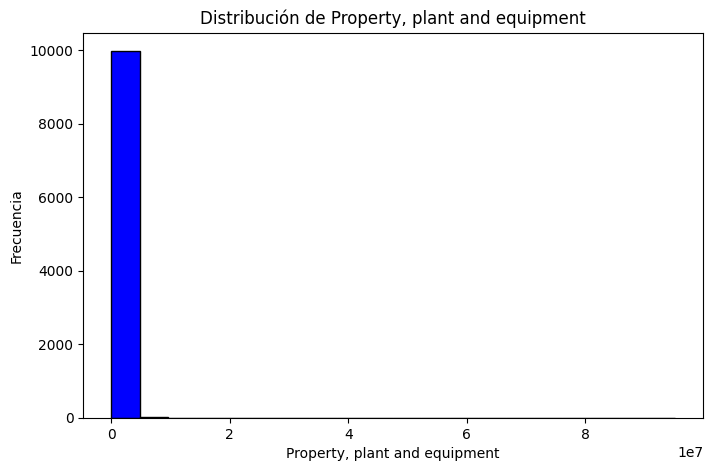

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(datos['Property, plant and equipment'], bins=20, color='blue', edgecolor='black')
plt.title('Distribución de Property, plant and equipment')
plt.xlabel('Property, plant and equipment')
plt.ylabel('Frecuencia')
plt.show()

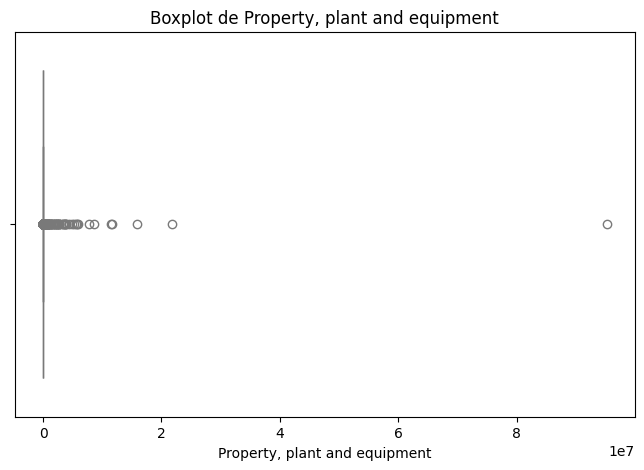

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos['Property, plant and equipment'], color='lightblue')
plt.title('Boxplot de Property, plant and equipment')
plt.show()

In [16]:
# Calcular el IQR
Q1 = datos['Property, plant and equipment'].quantile(0.25)
Q3 = datos['Property, plant and equipment'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 3 * IQR

# Filtrar los datos eliminando los outliers
datos_filtrados = datos[(datos['Property, plant and equipment'] >= lower_bound) & (datos['Property, plant and equipment'] <= upper_bound)]

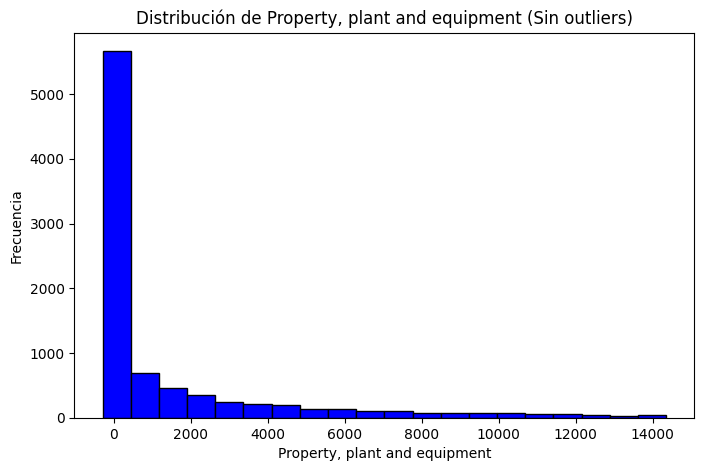

In [17]:
# Mostrar el histograma sin outliers
plt.figure(figsize=(8, 5))
plt.hist(datos_filtrados['Property, plant and equipment'], bins=20, color='blue', edgecolor='black')
plt.title('Distribución de Property, plant and equipment (Sin outliers)')
plt.xlabel('Property, plant and equipment')
plt.ylabel('Frecuencia')
plt.show()


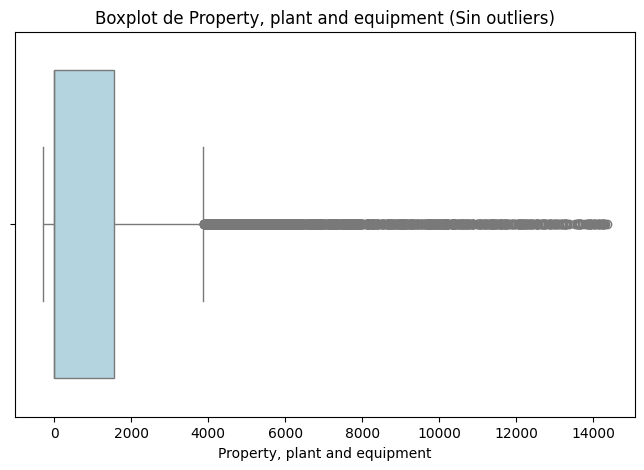

In [18]:
# Boxplot después de eliminar outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos_filtrados['Property, plant and equipment'], color='lightblue')
plt.title('Boxplot de Property, plant and equipment (Sin outliers)')
plt.show()

In [19]:
# Eliminar valores nulos en la columna 'Property, plant and equipment' para poder calcular las estadísticas
datos_clean = datos['Property, plant and equipment'].dropna()

# Calcular la kurtosis y la asimetría nuevamente después de limpiar los datos
kurt = kurtosis(datos_clean, fisher=False)  # Fisher=False para la definición clásica
skw = skew(datos_clean)

int(kurt), int(skw)

(7366, 81)

Nos indica que existe una asimetría muy grande, especificamente hacia la derecha

## Cash and Cash Equivalents

In [20]:
datos['Cash and Cash Equivalents'].describe()

count    5.683000e+03
mean     2.601415e+04
std      4.634983e+05
min      0.000000e+00
25%      5.069800e+02
50%      1.788070e+03
75%      6.158080e+03
max      2.078178e+07
Name: Cash and Cash Equivalents, dtype: float64

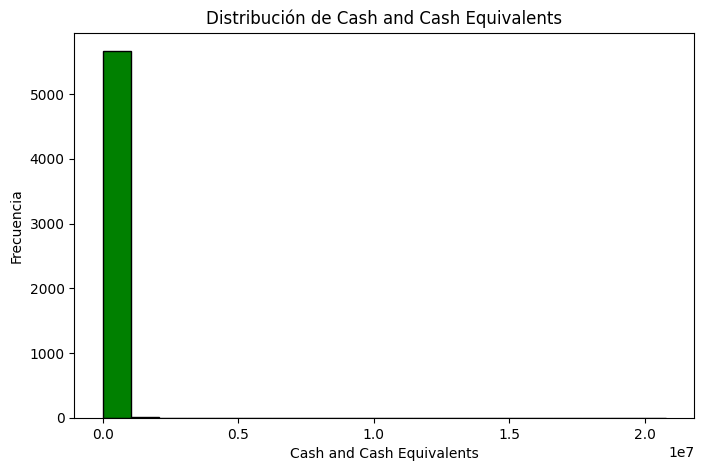

In [21]:
plt.figure(figsize=(8, 5))
plt.hist(datos['Cash and Cash Equivalents'].dropna(), bins=20, color='green', edgecolor='black')
plt.title('Distribución de Cash and Cash Equivalents')
plt.xlabel('Cash and Cash Equivalents')
plt.ylabel('Frecuencia')
plt.show()

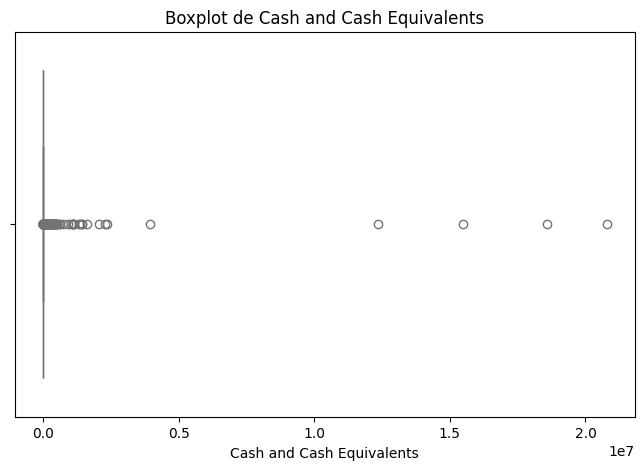

In [22]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos['Cash and Cash Equivalents'], color='lightgreen')
plt.title('Boxplot de Cash and Cash Equivalents')
plt.show()


In [23]:
# 3. Cálculo de la kurtosis y la asimetría (skewness)
datos_cash_clean = datos['Cash and Cash Equivalents'].dropna()

# Calcular la kurtosis
kurt_cash = kurtosis(datos_cash_clean, fisher=False)  # Fisher=False para la definición clásica
# Calcular la asimetría (skewness)
skw_cash = skew(datos_cash_clean)

print(f"Kurtosis: {kurt_cash}")
print(f"Asimetría: {skw_cash}")

Kurtosis: 1467.480840571364
Asimetría: 37.14348783374378


In [24]:
# Eliminar outliers de la columna 'Cash and Cash Equivalents' utilizando el IQR
Q1_cash = datos['Cash and Cash Equivalents'].quantile(0.25)
Q3_cash = datos['Cash and Cash Equivalents'].quantile(0.75)
IQR_cash = Q3_cash - Q1_cash

# Definir límites para eliminar los outliers
lower_bound_cash = Q1_cash - 1.5 * IQR_cash
upper_bound_cash = Q3_cash + 3 * IQR_cash

# Filtrar los datos eliminando los outliers
datos_filtrados_cash = datos[(datos['Cash and Cash Equivalents'] >= lower_bound_cash) & 
                             (datos['Cash and Cash Equivalents'] <= upper_bound_cash)]


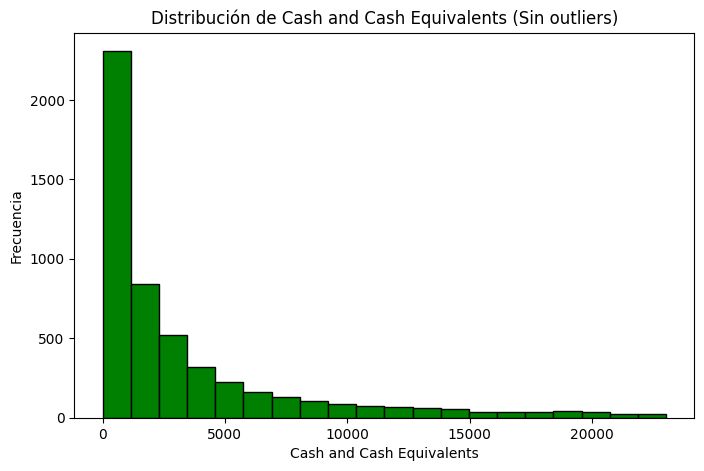

In [25]:
# Visualizar el histograma sin outliers
plt.figure(figsize=(8, 5))
plt.hist(datos_filtrados_cash['Cash and Cash Equivalents'], bins=20, color='green', edgecolor='black')
plt.title('Distribución de Cash and Cash Equivalents (Sin outliers)')
plt.xlabel('Cash and Cash Equivalents')
plt.ylabel('Frecuencia')
plt.show()

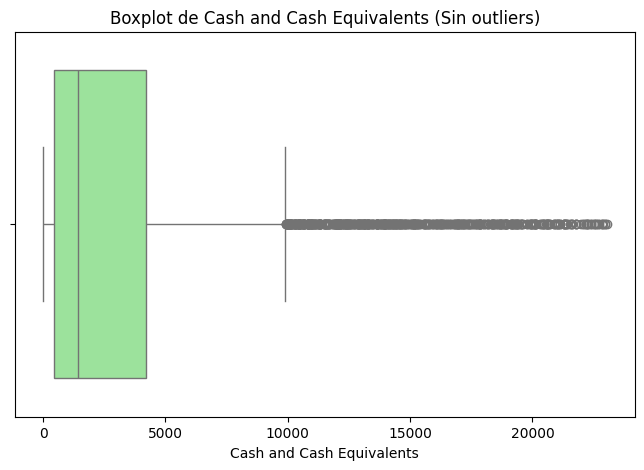

In [26]:
# Boxplot después de eliminar outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos_filtrados_cash['Cash and Cash Equivalents'], color='lightgreen')
plt.title('Boxplot de Cash and Cash Equivalents (Sin outliers)')
plt.show()

## Net Sales Revenue Trend (%)

In [27]:
datos["Net Sales Revenue Trend (%)"].describe()

count    9.095000e+03
mean     4.588666e+02
std      1.548551e+04
min     -1.000000e+02
25%     -2.645000e+00
50%      1.271000e+01
75%      3.482000e+01
max      1.385964e+06
Name: Net Sales Revenue Trend (%), dtype: float64

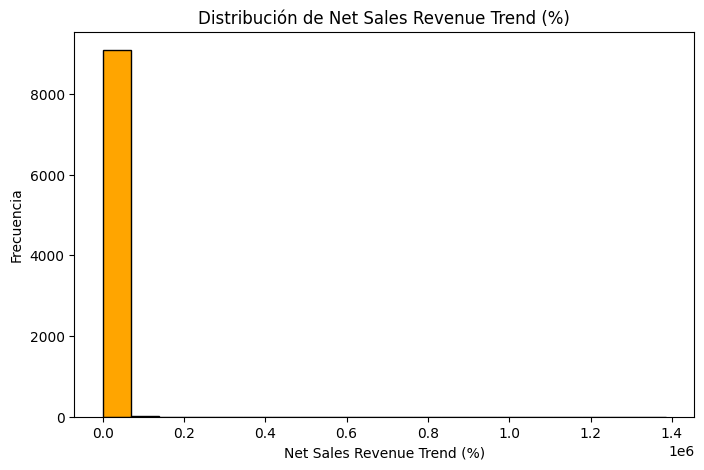

In [28]:
plt.figure(figsize=(8, 5))
plt.hist(datos['Net Sales Revenue Trend (%)'].dropna(), bins=20, color='orange', edgecolor='black')
plt.title('Distribución de Net Sales Revenue Trend (%)')
plt.xlabel('Net Sales Revenue Trend (%)')
plt.ylabel('Frecuencia')
plt.show()

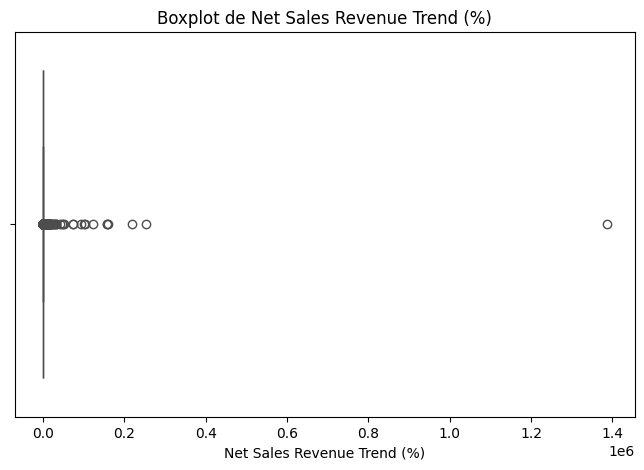

In [29]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos['Net Sales Revenue Trend (%)'], color='orange')
plt.title('Boxplot de Net Sales Revenue Trend (%)')
plt.show()

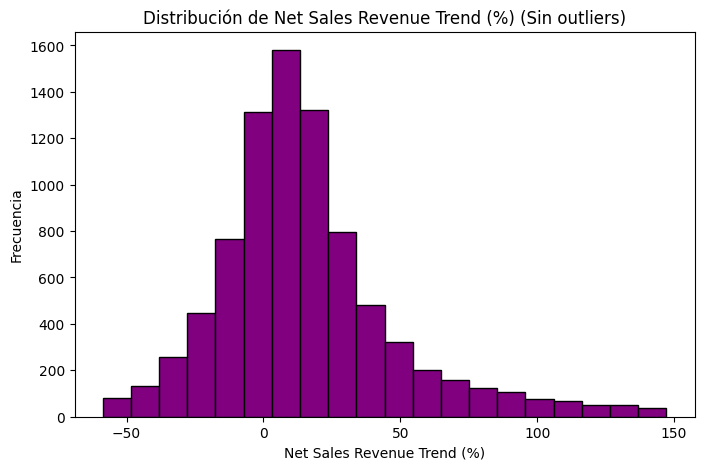

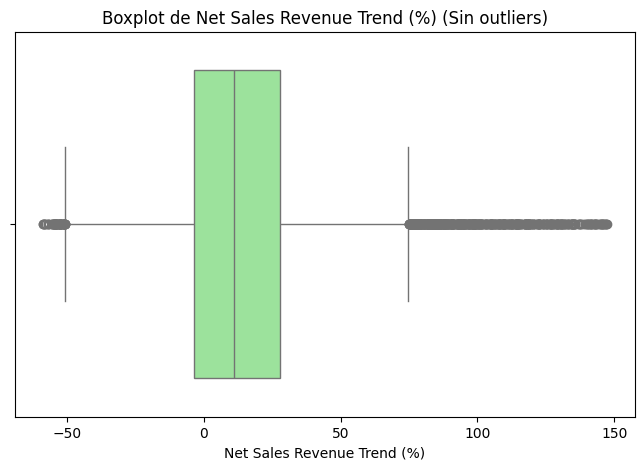

Kurtosis: 5.210733446864647
Asimetría: 1.141799347736582


In [30]:
# Eliminar outliers de la columna 'Net Sales Revenue Trend (%)' utilizando el IQR
Q1_sales = datos['Net Sales Revenue Trend (%)'].quantile(0.25)
Q3_sales = datos['Net Sales Revenue Trend (%)'].quantile(0.75)
IQR_sales = Q3_sales - Q1_sales

# Definir límites para eliminar los outliers
lower_bound_sales = Q1_sales - 1.5 * IQR_sales
upper_bound_sales = Q3_sales + 3 * IQR_sales

# Filtrar los datos eliminando los outliers
datos_filtrados_sales = datos[(datos['Net Sales Revenue Trend (%)'] >= lower_bound_sales) & 
                             (datos['Net Sales Revenue Trend (%)'] <= upper_bound_sales)]

# Visualizar el histograma sin outliers
plt.figure(figsize=(8, 5))
plt.hist(datos_filtrados_sales['Net Sales Revenue Trend (%)'], bins=20, color='purple', edgecolor='black')
plt.title('Distribución de Net Sales Revenue Trend (%) (Sin outliers)')
plt.xlabel('Net Sales Revenue Trend (%)')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot después de eliminar outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos_filtrados_sales['Net Sales Revenue Trend (%)'], color='lightgreen')
plt.title('Boxplot de Net Sales Revenue Trend (%) (Sin outliers)')
plt.show()

# Cálculo de la kurtosis y la asimetría (skewness)
datos_sales_clean = datos_filtrados_sales['Net Sales Revenue Trend (%)'].dropna()

# Calcular la kurtosis
kurt_sales = kurtosis(datos_sales_clean, fisher=False)  # Fisher=False para la definición clásica
# Calcular la asimetría (skewness)
skw_sales = skew(datos_sales_clean)

print(f"Kurtosis: {kurt_sales}")
print(f"Asimetría: {skw_sales}")

## Operating Profit Trend (%)

In [31]:
datos["Operating Profit Trend (%)"].describe()

count    9.101000e+03
mean     3.909004e+02
std      2.758651e+04
min     -5.336668e+05
25%     -5.263000e+01
50%     -1.020000e+00
75%      5.874000e+01
max      1.890345e+06
Name: Operating Profit Trend (%), dtype: float64

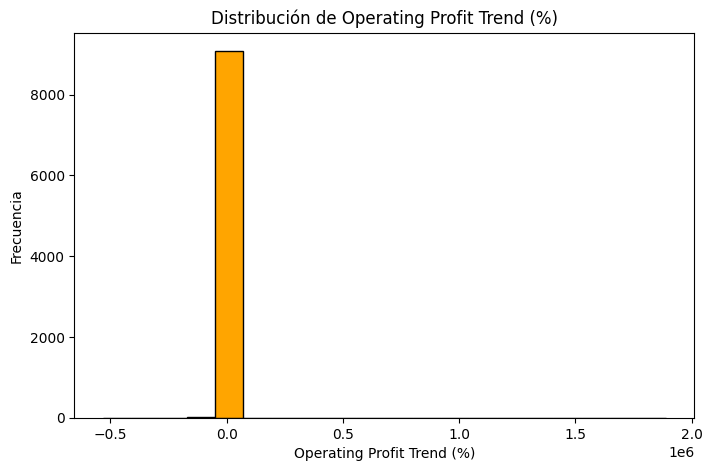

In [32]:
plt.figure(figsize=(8, 5))
plt.hist(datos['Operating Profit Trend (%)'].dropna(), bins=20, color='orange', edgecolor='black')
plt.title('Distribución de Operating Profit Trend (%)')
plt.xlabel('Operating Profit Trend (%)')
plt.ylabel('Frecuencia')
plt.show()

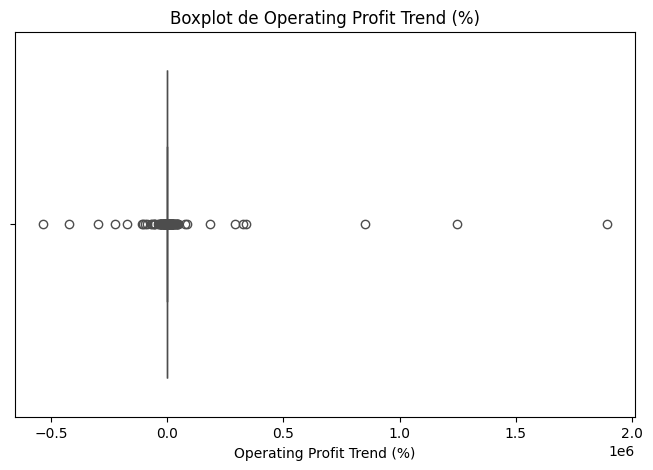

In [33]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos['Operating Profit Trend (%)'], color='orange')
plt.title('Boxplot de Operating Profit Trend (%)')
plt.show()

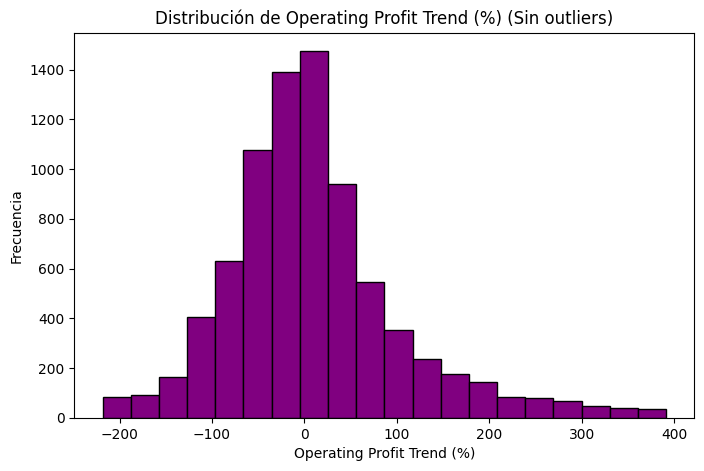

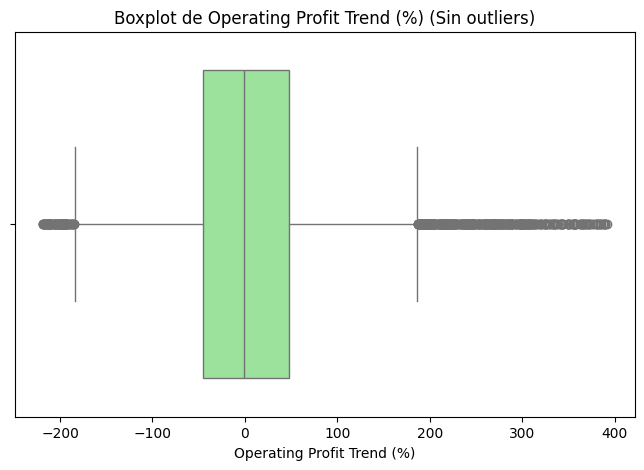

Kurtosis: 5430.08855795243
Asimetría: 70.39166071984562


In [34]:
# Eliminar outliers de la columna 'Net Sales Revenue Trend (%)' utilizando el IQR
Q1_sales = datos['Operating Profit Trend (%)'].quantile(0.25)
Q3_sales = datos['Operating Profit Trend (%)'].quantile(0.75)
IQR_sales = Q3_sales - Q1_sales

# Definir límites para eliminar los outliers
lower_bound_sales = Q1_sales - 1.5 * IQR_sales
upper_bound_sales = Q3_sales + 3 * IQR_sales

# Filtrar los datos eliminando los outliers
datos_filtrados_profit = datos[(datos['Operating Profit Trend (%)'] >= lower_bound_sales) & 
                             (datos['Operating Profit Trend (%)'] <= upper_bound_sales)]

# Visualizar el histograma sin outliers
plt.figure(figsize=(8, 5))
plt.hist(datos_filtrados_profit['Operating Profit Trend (%)'], bins=20, color='purple', edgecolor='black')
plt.title('Distribución de Operating Profit Trend (%) (Sin outliers)')
plt.xlabel('Operating Profit Trend (%)')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot después de eliminar outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos_filtrados_profit['Operating Profit Trend (%)'], color='lightgreen')
plt.title('Boxplot de Operating Profit Trend (%) (Sin outliers)')
plt.show()

# Cálculo de la kurtosis y la asimetría (skewness)
datos_profit_clean = datos_filtrados_sales['Operating Profit Trend (%)'].dropna()

# Calcular la kurtosis
kurt_sales = kurtosis(datos_profit_clean, fisher=False)  # Fisher=False para la definición clásica
# Calcular la asimetría (skewness)
skw_sales = skew(datos_profit_clean)

print(f"Kurtosis: {kurt_sales}")
print(f"Asimetría: {skw_sales}")

## Paises de importación y exportación

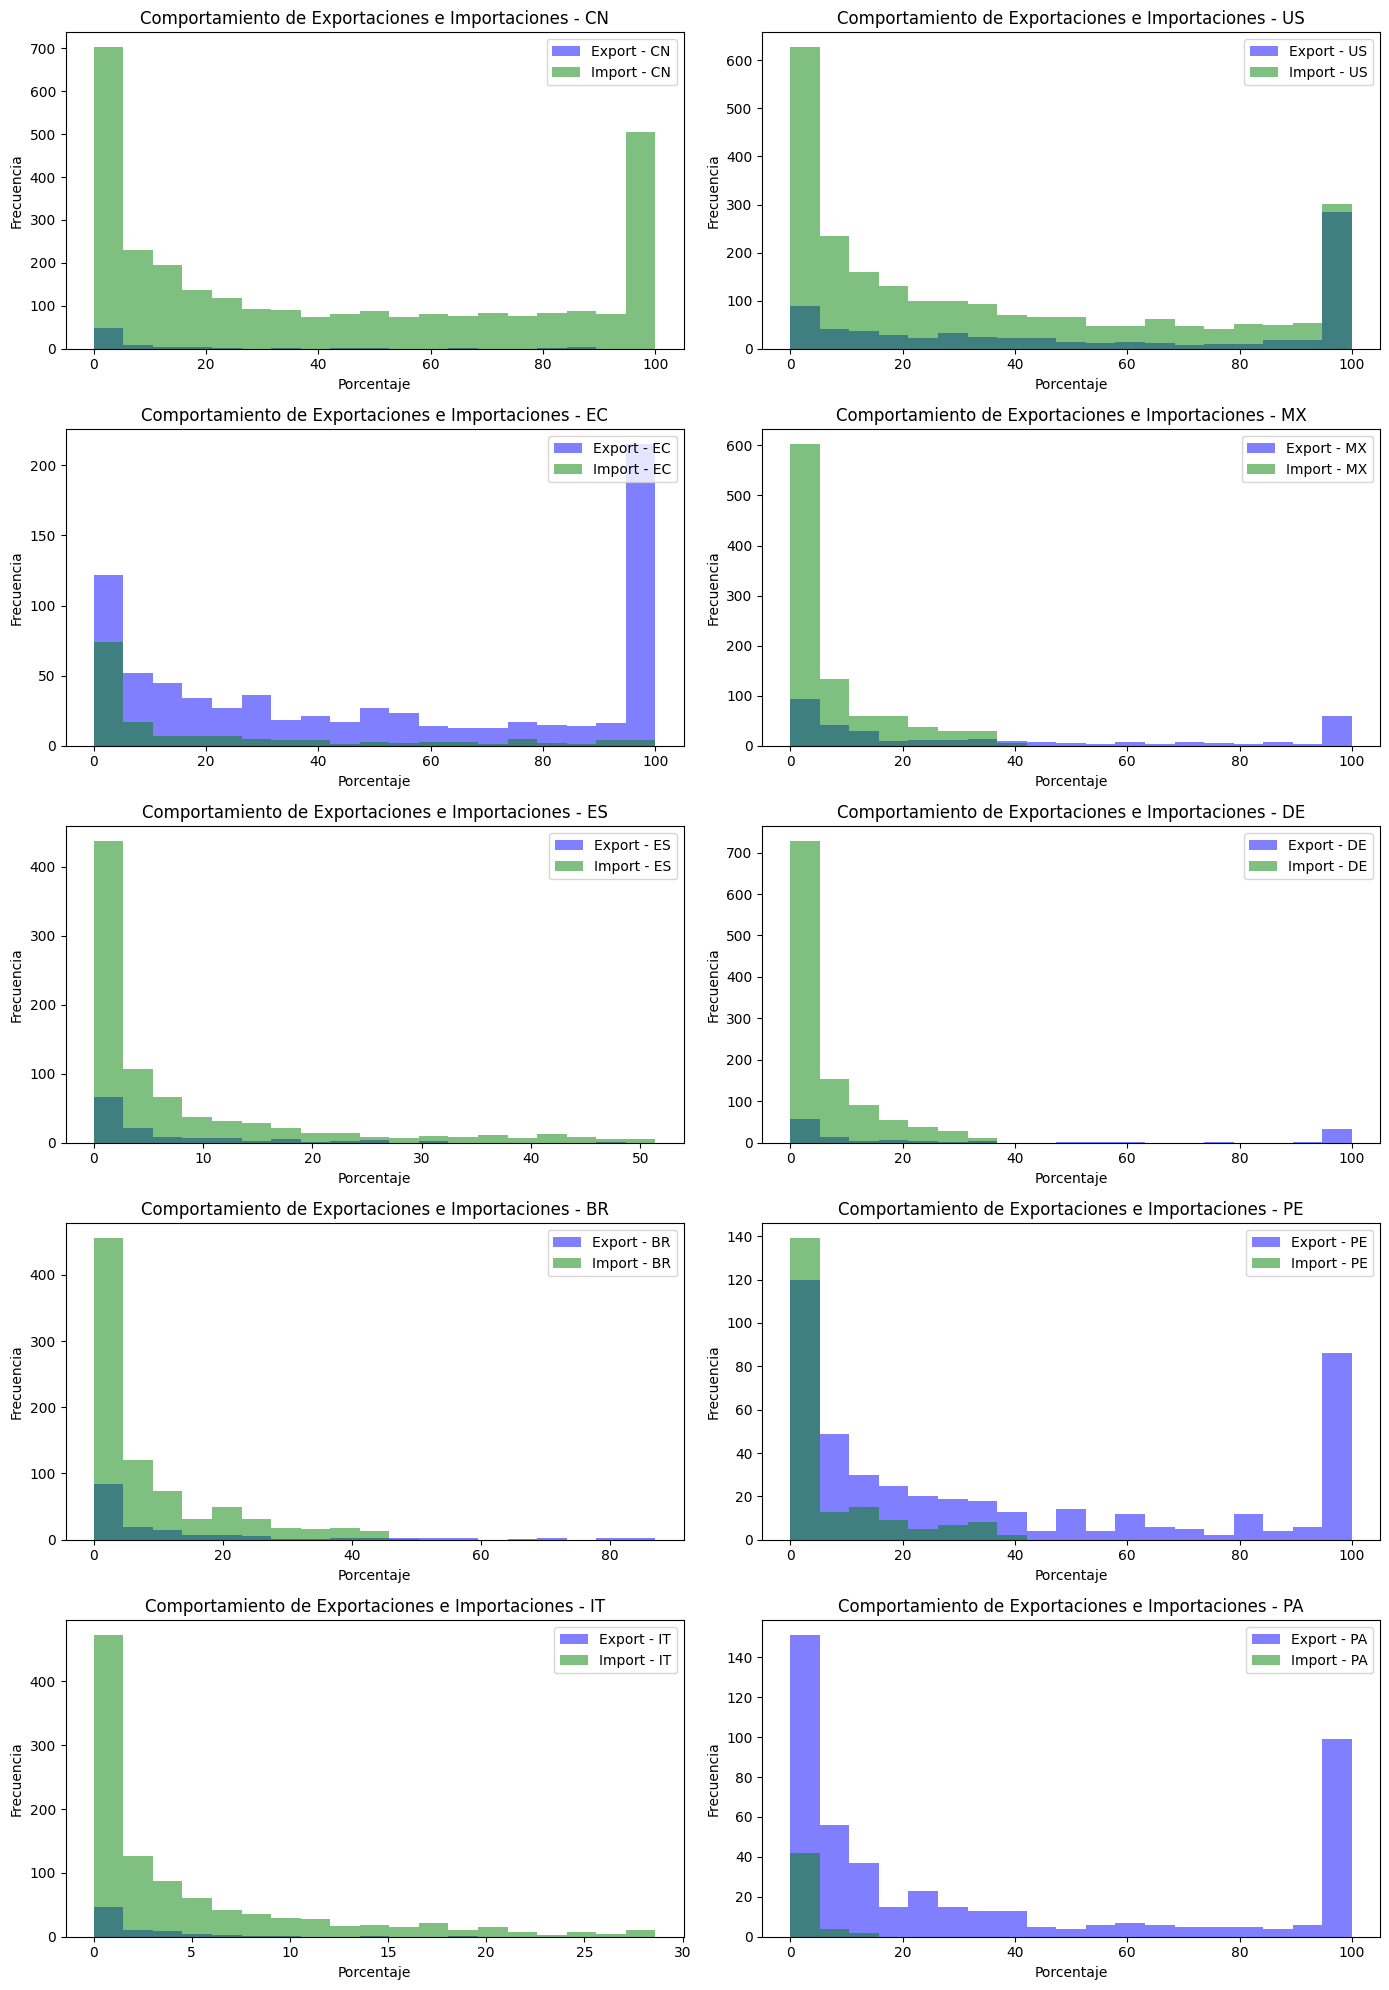

In [35]:
def remove_outliers_iqr(data_column):
    Q1 = data_column.quantile(0.25)
    Q3 = data_column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1 * IQR
    upper_bound = Q3 + 1 * IQR
    return data_column[(data_column >= lower_bound) & (data_column <= upper_bound)]

# Función para eliminar valores en cero
def remove_zero_values(data_column):
    return data_column[data_column != 0]

# Obtener las columnas de exportación e importación del top 10 de países
top_10_export_columns = [col for col in datos.columns if 'Export_' in col]
top_10_import_columns = [col for col in datos.columns if 'Import_' in col]

# Crear un gráfico combinado de subplots para exportaciones e importaciones por país
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))  # 5 filas, 2 columnas

# Aplanar los ejes para facilitar el acceso
axes = axes.flatten()

# Iterar sobre las columnas de exportación e importación, eliminar outliers y graficar
for i, (export_col, import_col) in enumerate(zip(top_10_export_columns, top_10_import_columns)):
    # Limpiar los datos: eliminar outliers y valores en cero
    export_data_clean = remove_outliers_iqr(remove_zero_values(datos[export_col].dropna()))
    import_data_clean = remove_outliers_iqr(remove_zero_values(datos[import_col].dropna()))

    # Determinar el rango de los bins utilizando el valor mínimo y máximo entre ambas series (exportaciones e importaciones)
    min_value = min(export_data_clean.min(), import_data_clean.min())
    max_value = max(export_data_clean.max(), import_data_clean.max())

    # Definir los bins comunes para exportaciones e importaciones
    bins = np.linspace(min_value, max_value, 20)

    # Histograma de exportaciones
    axes[i].hist(export_data_clean, bins=bins, alpha=0.5, label=f'Export - {export_col.split("_")[1]}', color='blue')
    
    # Histograma de importaciones
    axes[i].hist(import_data_clean, bins=bins, alpha=0.5, label=f'Import - {import_col.split("_")[1]}', color='green')
    
    # Título y etiquetas
    country_name = export_col.split("_")[1]  # Obtener el nombre del país
    axes[i].set_title(f'Comportamiento de Exportaciones e Importaciones - {country_name}')
    axes[i].set_xlabel('Porcentaje')
    axes[i].set_ylabel('Frecuencia')
    axes[i].legend(loc='upper right')

# Ajustar el layout
plt.tight_layout()
plt.show()


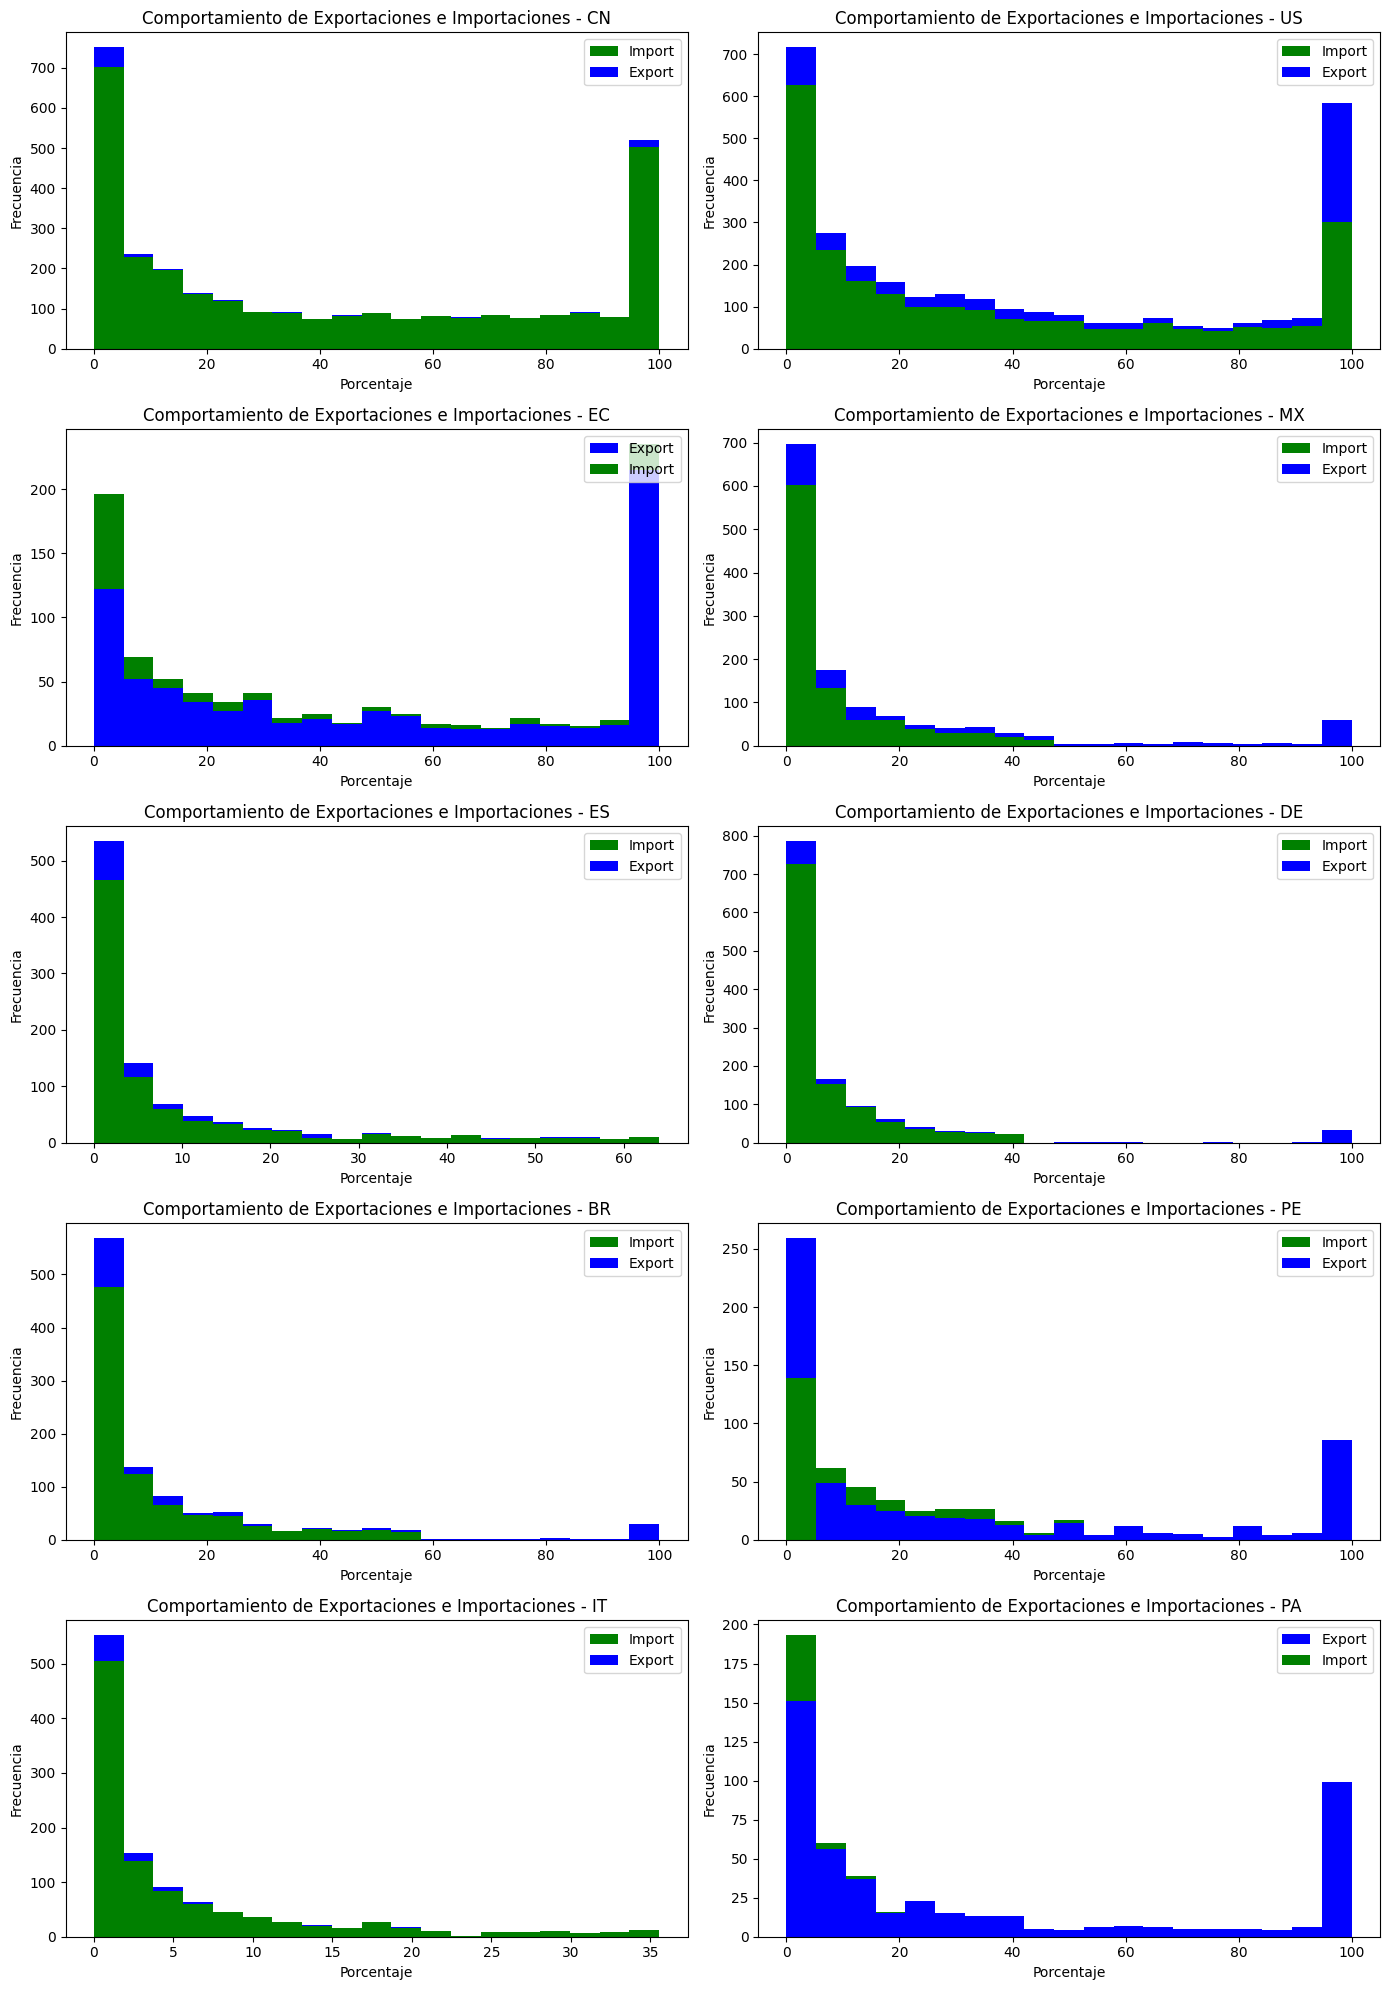

In [36]:
# Función para eliminar outliers utilizando el IQR (Rango Intercuartílico)
def remove_outliers_iqr(data_column):
    Q1 = data_column.quantile(0.25)
    Q3 = data_column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data_column[(data_column >= lower_bound) & (data_column <= upper_bound)]

# Función para eliminar valores en cero
def remove_zero_values(data_column):
    return data_column[data_column != 0]

# Obtener las columnas de exportación e importación del top 10 de países
top_10_export_columns = [col for col in datos.columns if 'Export_' in col]
top_10_import_columns = [col for col in datos.columns if 'Import_' in col]

# Crear un gráfico combinado de subplots para exportaciones e importaciones por país
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))  # 5 filas, 2 columnas

# Aplanar los ejes para facilitar el acceso
axes = axes.flatten()

# Iterar sobre las columnas de exportación e importación, eliminar outliers y graficar
for i, (export_col, import_col) in enumerate(zip(top_10_export_columns, top_10_import_columns)):
    # Limpiar los datos: eliminar outliers y valores en cero
    export_data_clean = remove_outliers_iqr(remove_zero_values(datos[export_col].dropna()))
    import_data_clean = remove_outliers_iqr(remove_zero_values(datos[import_col].dropna()))

    # Determinar el rango de los bins utilizando el valor mínimo y máximo entre ambas series (exportaciones e importaciones)
    min_value = min(export_data_clean.min(), import_data_clean.min())
    max_value = max(export_data_clean.max(), import_data_clean.max())

    # Definir los bins comunes para exportaciones e importaciones
    bins = np.linspace(min_value, max_value, 20)

    # Obtener los valores de los histogramas (sin plotearlos)
    export_hist, _ = np.histogram(export_data_clean, bins=bins)
    import_hist, _ = np.histogram(import_data_clean, bins=bins)

    # Dibujar las barras apiladas
    for j in range(len(bins) - 1):
        # El bin mayor será la base
        if export_hist[j] > import_hist[j]:
            axes[i].bar(bins[j], export_hist[j], width=bins[j+1] - bins[j], color='blue', align='edge', label='Export' if j == 0 else "")
            axes[i].bar(bins[j], import_hist[j], width=bins[j+1] - bins[j], bottom=export_hist[j], color='green', align='edge', label='Import' if j == 0 else "")
        else:
            axes[i].bar(bins[j], import_hist[j], width=bins[j+1] - bins[j], color='green', align='edge', label='Import' if j == 0 else "")
            axes[i].bar(bins[j], export_hist[j], width=bins[j+1] - bins[j], bottom=import_hist[j], color='blue', align='edge', label='Export' if j == 0 else "")

    # Título y etiquetas
    country_name = export_col.split("_")[1]  # Obtener el nombre del país
    axes[i].set_title(f'Comportamiento de Exportaciones e Importaciones - {country_name}')
    axes[i].set_xlabel('Porcentaje')
    axes[i].set_ylabel('Frecuencia')

    # Añadir la leyenda solo una vez en cada gráfico
    axes[i].legend(loc='upper right')

# Ajustar el layout
plt.tight_layout()
plt.show()

# Análisis multivariado

In [37]:
datos = datos.drop(["Import", "Export", "Industry (NAICS)"], axis=1)

In [38]:
datos.head()

,Company,"Property, plant and equipment",Cash and Cash Equivalents,Net Sales Revenue Trend (%),Operating Profit Trend (%),Export_CN,Import_CN,Export_US,Import_US,Export_EC,...,Import_DE,Export_BR,Import_BR,Export_PE,Import_PE,Export_IT,Import_IT,Export_PA,Import_PA,First_Sector
0,Ecopetrol S.A.,95171301.60,12336115.05,-10.28,-30.69,10.36,0.13,32.37,71.54,0.00,...,0.15,0.0,2.56,0.39,0.00,0.0,0.23,28.55,0.0,Natural Gas Extraction(21113)
1,Organizacion Terpel S.A.,3939357.24,916490.75,2.17,10.06,0.00,0.38,21.37,96.06,3.59,...,0.45,0.1,0.00,0.58,0.45,0.0,0.08,4.19,0.0,Petroleum and Petroleum Products Merchant Whol...
2,D1 S A S,3379990.01,718512.83,24.88,1.75,0.00,8.14,0.00,0.00,100.00,...,3.29,0.0,0.12,0.00,2.55,0.0,11.84,0.00,0.0,Grocery Stores(4451)
3,Enel Colombia S.A. E.S.P.,21758779.81,1629477.08,37.18,-3.57,0.00,80.97,0.08,0.43,0.00,...,0.07,0.0,1.25,0.00,1.02,0.0,4.27,99.92,0.0,Electric Power Generation(22111)
4,Drummond Ltd,5480302.25,169861.35,1.55,6.54,3.08,3.14,3.74,66.98,0.00,...,13.18,2.8,0.56,0.00,0.00,0.0,1.60,1.66,0.0,Support Activities for Oil and Gas Operations(...


In [39]:
datos.to_csv("datos/Pruebas.csv")

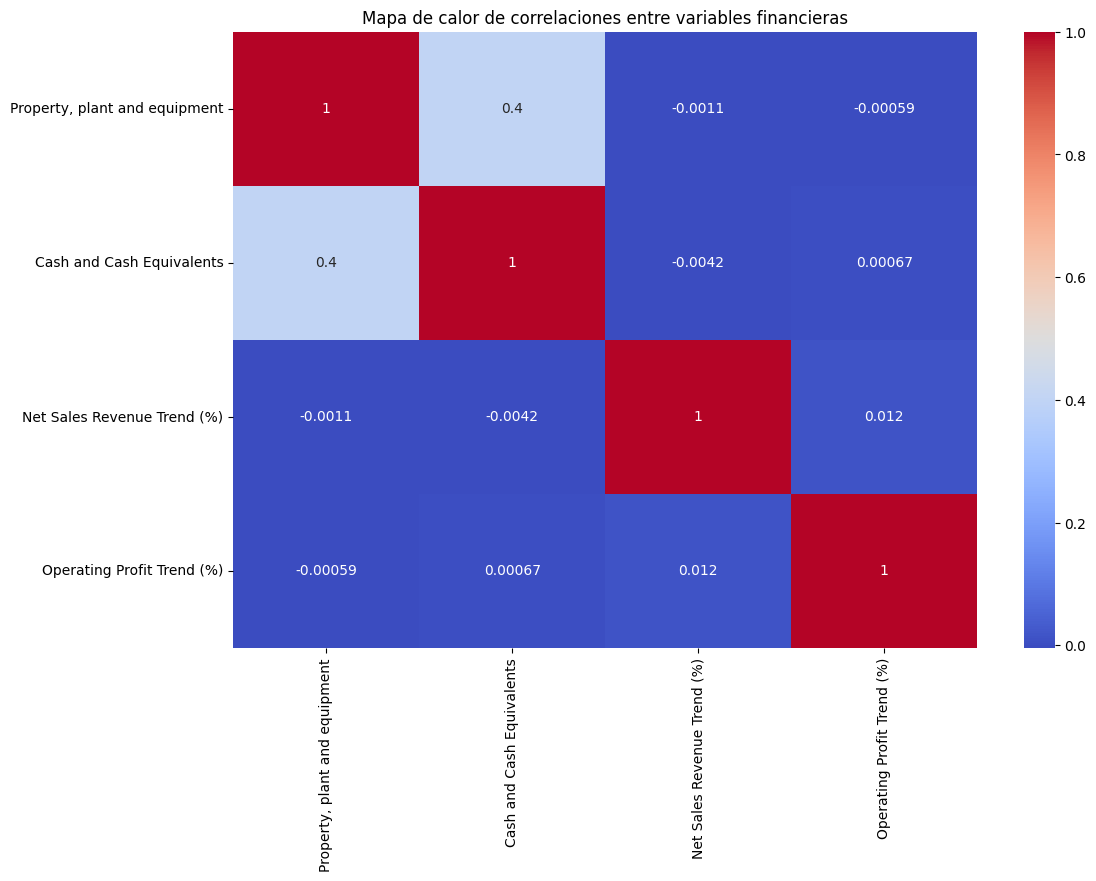

In [40]:
# Mapa de calor: Correlación entre variables financieras
plt.figure(figsize=(12,8))
sns.heatmap(datos[['Property, plant and equipment', 'Cash and Cash Equivalents', 
                'Net Sales Revenue Trend (%)', 'Operating Profit Trend (%)']].corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de calor de correlaciones entre variables financieras')
plt.show()

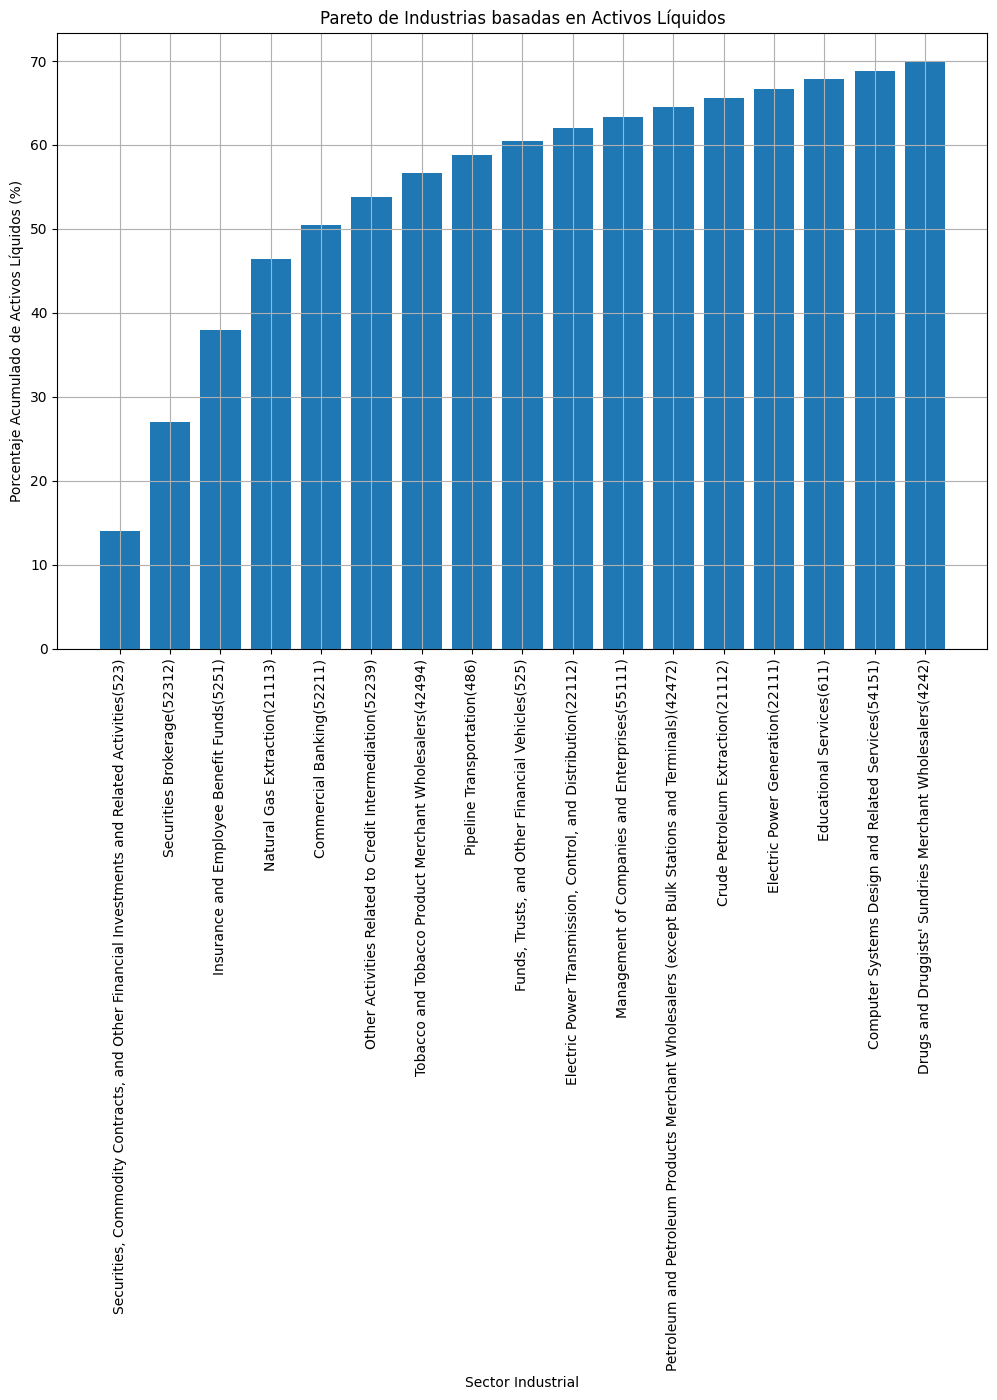

First_Sector
Securities, Commodity Contracts, and Other Financial Investments and Related Activities(523)         14.063537
Securities Brokerage(52312)                                                                          26.989798
Insurance and Employee Benefit Funds(5251)                                                           37.916634
Natural Gas Extraction(21113)                                                                        46.418787
Commercial Banking(52211)                                                                            50.469080
Other Activities Related to Credit Intermediation(52239)                                             53.828931
Tobacco and Tobacco Product Merchant Wholesalers(42494)                                              56.627328
Pipeline Transportation(486)                                                                         58.831835
Funds, Trusts, and Other Financial Vehicles(525)                                                   

In [49]:
# Agrupar por industria y sumar los 'Cash and Cash Equivalents'
industry_totals = datos.groupby('First_Sector')['Cash and Cash Equivalents'].sum().sort_values(ascending=False)

# Calcular el porcentaje acumulado
cumulative_percentage = industry_totals.cumsum() / industry_totals.sum() * 100

# Identificar las industrias que representan el 80% del total (principio de Pareto)
pareto_threshold = cumulative_percentage[cumulative_percentage <= 70]

# Visualizar el gráfico de Pareto
plt.figure(figsize=(12,8))
plt.bar(pareto_threshold.index, pareto_threshold.values)
plt.title('Pareto de Industrias basadas en Activos Líquidos')
plt.xlabel('Sector Industrial')
plt.ylabel('Porcentaje Acumulado de Activos Líquidos (%)')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Mostrar las industrias que representan el 80%
pareto_threshold


In [57]:

def graficar_box_por_industria(columna, IQR_PROP = 1.5):
    # Filtrar el DataFrame original para incluir solo las industrias del análisis de Pareto (top 20%)
    pareto_industries = pareto_threshold.index
    filtered_df = datos[datos['First_Sector'].isin(pareto_industries)]

    # Calcular los límites de los outliers utilizando el rango intercuartílico (IQR)
    Q1 = filtered_df[columna].quantile(0.25)
    Q3 = filtered_df[columna].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites inferior y superior para los valores no considerados outliers
    lower_bound = Q1 - IQR_PROP * IQR
    upper_bound = Q3 + IQR_PROP * IQR

    # Filtrar los datos eliminando los outliers
    filtered_df_no_outliers = filtered_df[(filtered_df[columna] >= lower_bound) & 
                                        (filtered_df[columna] <= upper_bound)]

    # Crear el boxplot sin los outliers
    plt.figure(figsize=(12,8))
    sns.boxplot(x='First_Sector', y=columna, data=filtered_df_no_outliers)
    plt.title('Distribución de Activos Líquidos en las Principales Industrias (Sin Outliers)')
    plt.xlabel('Sector Industrial')
    plt.ylabel(columna)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()


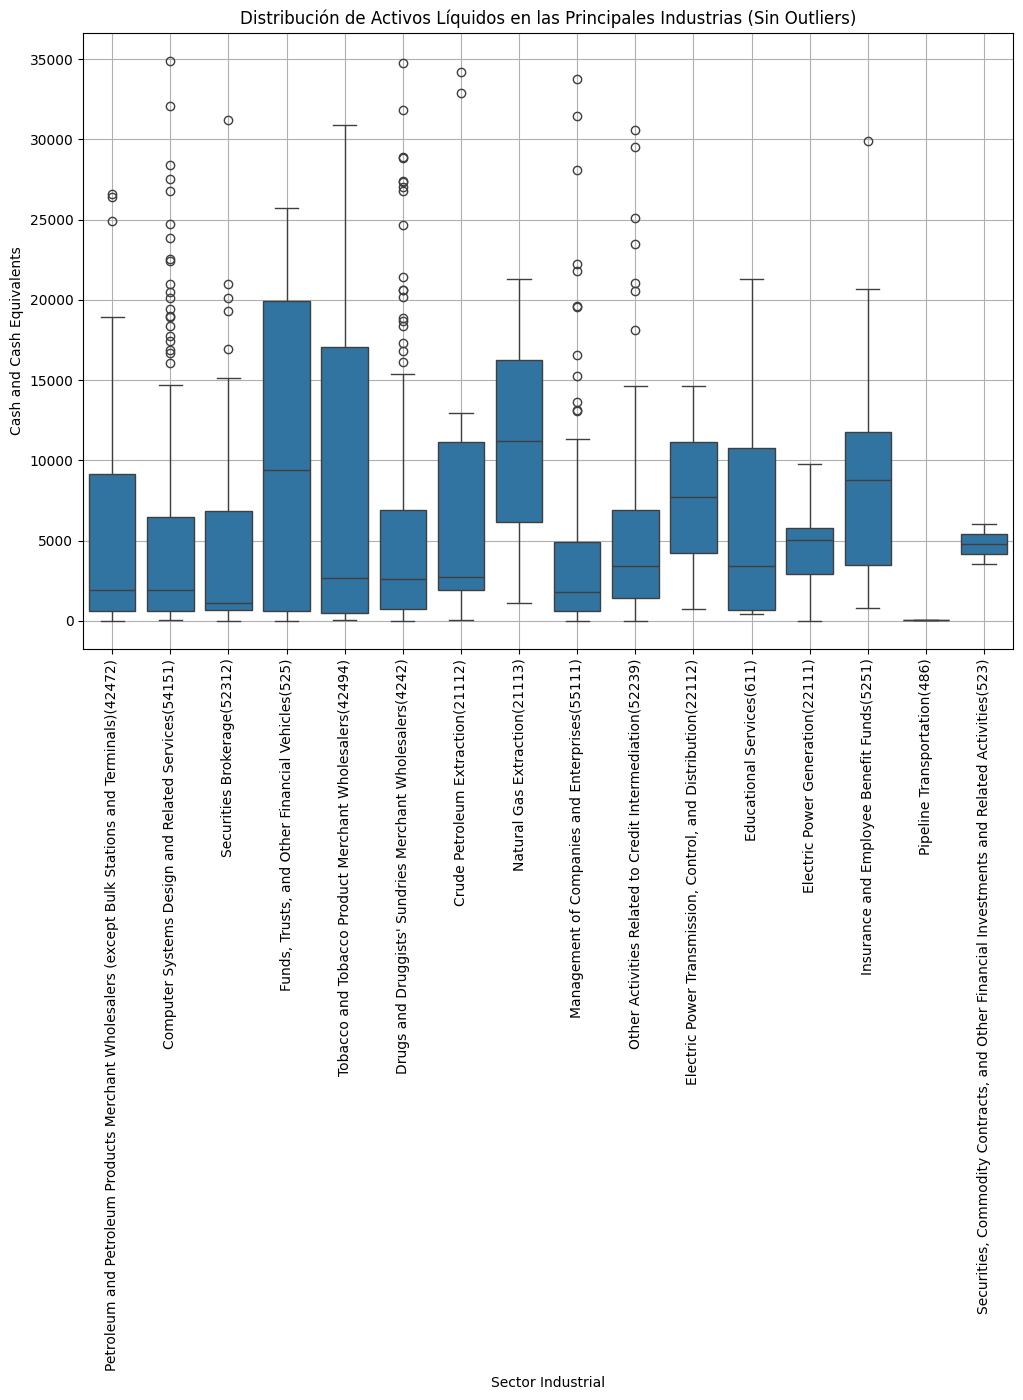

In [58]:
graficar_box_por_industria('Cash and Cash Equivalents')

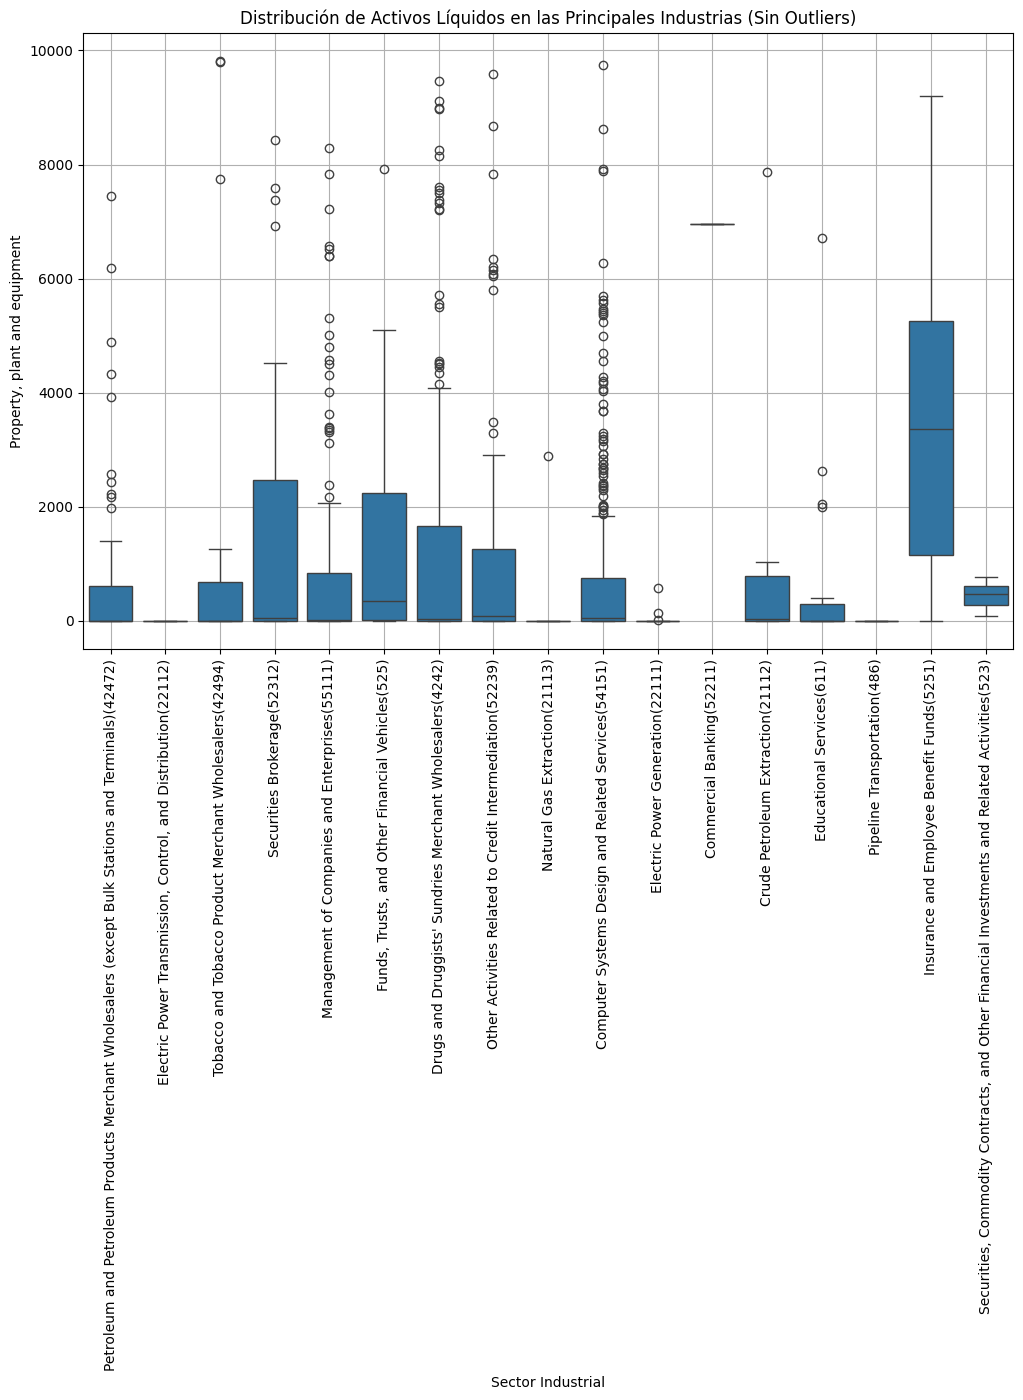

In [61]:
graficar_box_por_industria('Property, plant and equipment', IQR_PROP=3)

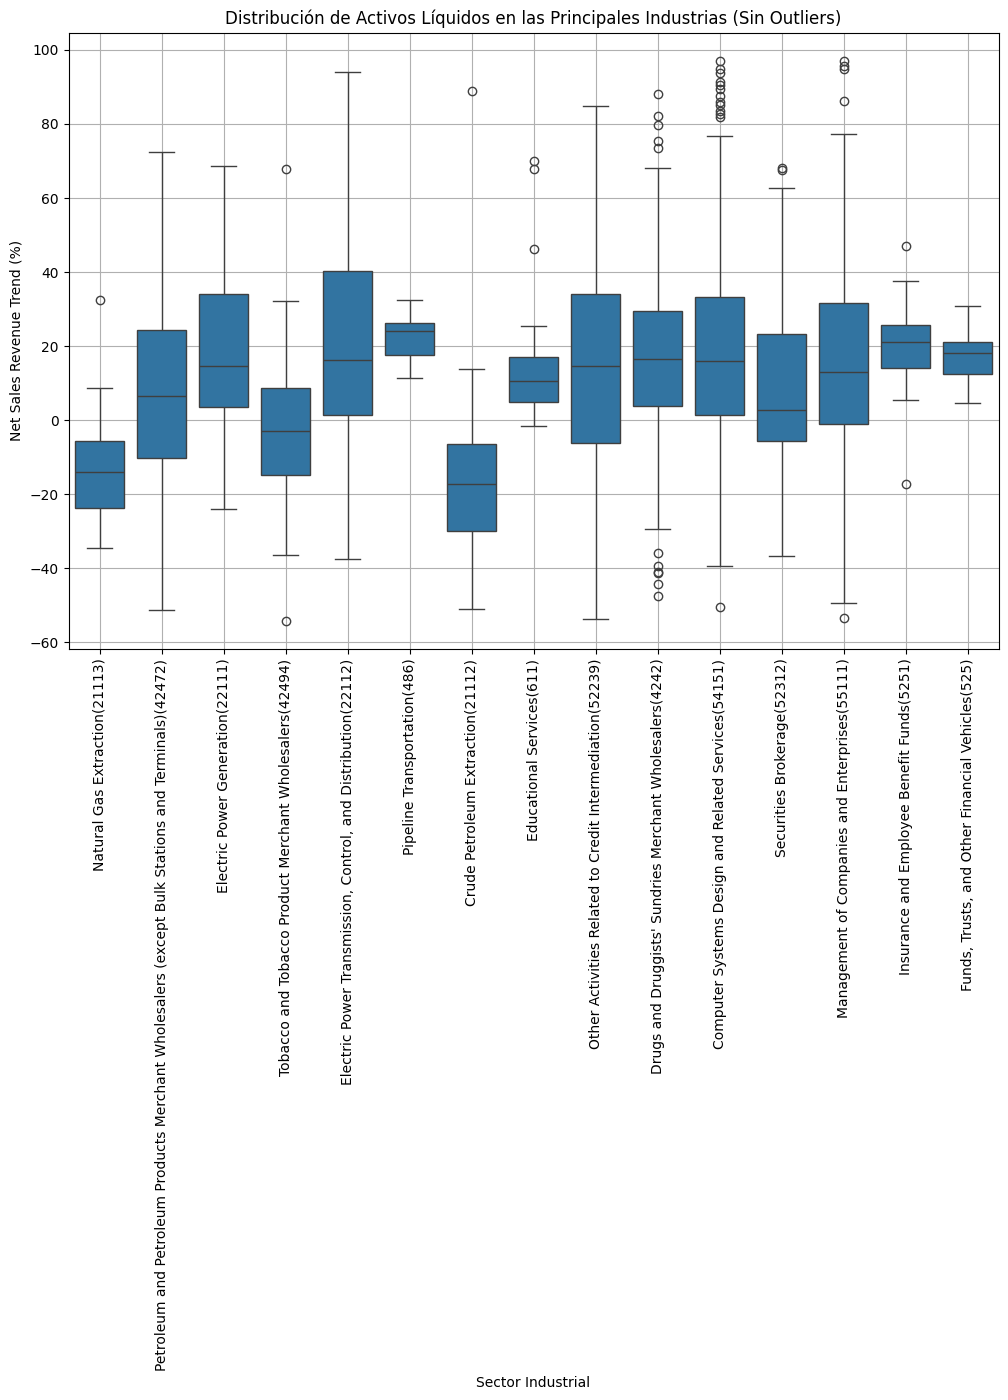

In [62]:
graficar_box_por_industria('Net Sales Revenue Trend (%)', IQR_PROP=1.5)

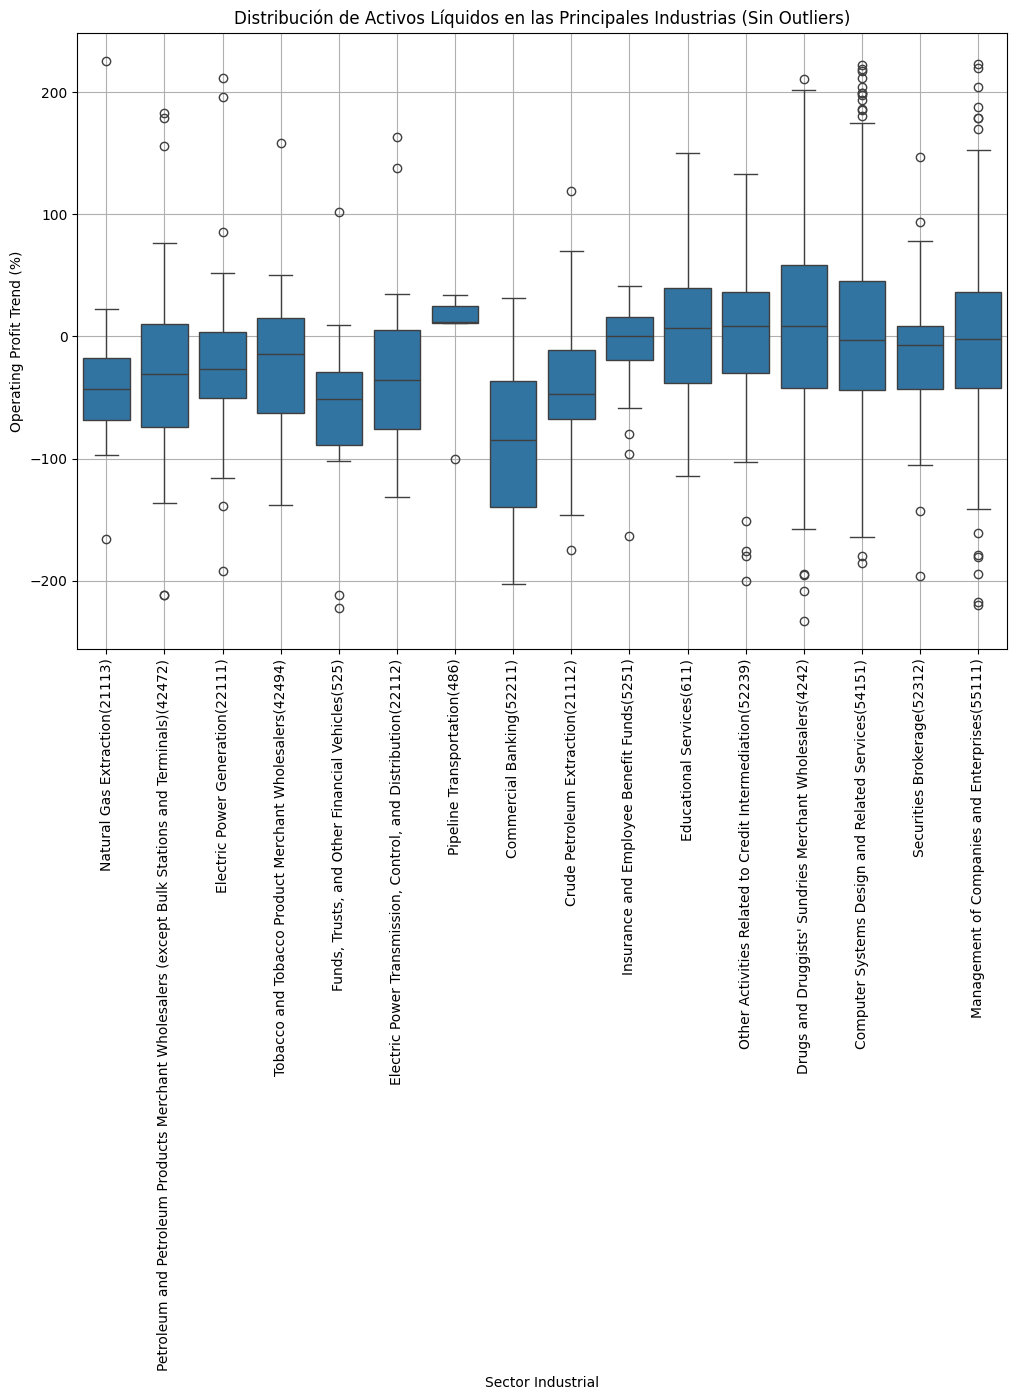

In [63]:
graficar_box_por_industria('Operating Profit Trend (%)', IQR_PROP=1.5)

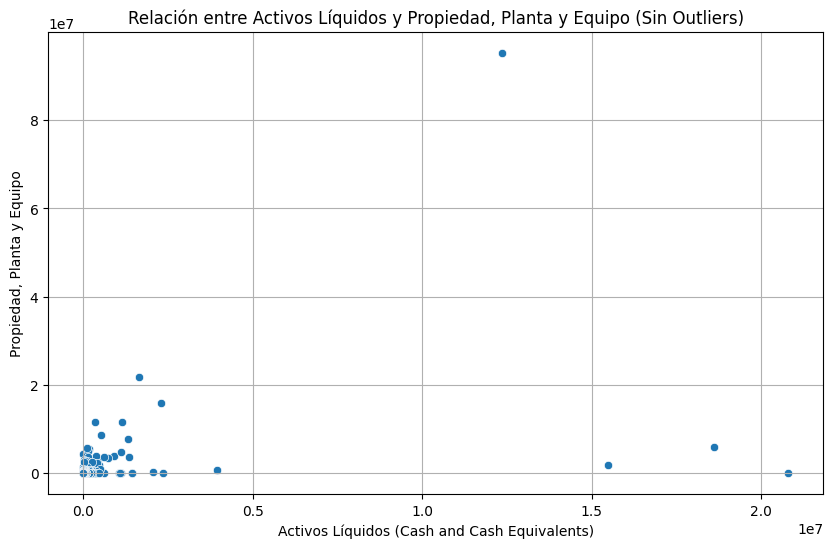

In [65]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=datos, x='Cash and Cash Equivalents', y='Property, plant and equipment')
plt.title('Relación entre Activos Líquidos y Propiedad, Planta y Equipo (Sin Outliers)')
plt.xlabel('Activos Líquidos (Cash and Cash Equivalents)')
plt.ylabel('Propiedad, Planta y Equipo')
plt.grid(True)
plt.show()

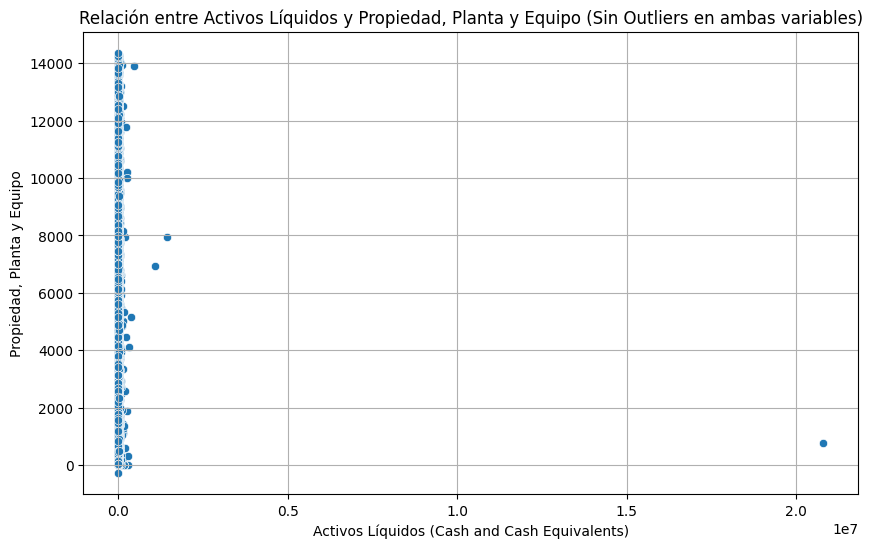

In [66]:
# Calcular los límites de los outliers para 'Property, plant and equipment' utilizando el IQR
Q1_property = datos['Property, plant and equipment'].quantile(0.25)
Q3_property = datos['Property, plant and equipment'].quantile(0.75)
IQR_property = Q3_property - Q1_property

# Definir los límites inferior y superior para 'Property, plant and equipment'
lower_bound_property = Q1_property - 3 * IQR_property
upper_bound_property = Q3_property + 3 * IQR_property

# Filtrar los datos eliminando los outliers de 'Property, plant and equipment'
filtered_df_no_outliers_properties = datos[(datos['Property, plant and equipment'] >= lower_bound_property) & 
                                                             (datos['Property, plant and equipment'] <= upper_bound_property)]

# Crear un gráfico de dispersión sin los outliers en ambas variables
plt.figure(figsize=(10,6))
sns.scatterplot(data=filtered_df_no_outliers_properties, x='Cash and Cash Equivalents', y='Property, plant and equipment')
plt.title('Relación entre Activos Líquidos y Propiedad, Planta y Equipo (Sin Outliers en ambas variables)')
plt.xlabel('Activos Líquidos (Cash and Cash Equivalents)')
plt.ylabel('Propiedad, Planta y Equipo')
plt.grid(True)
plt.show()


/var/folders/2b/4s639x9s6qn54sbrtyhszj180000gn/T/ipykernel_59170/230148785.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_clean['log_Cash_and_Cash_Equivalents'] = np.log(filtered_df_clean['Cash and Cash Equivalents'] + 1)
/Users/juandanielcastrellon/Documents/Universidad/Maestría/Semestre1/CienciaDeDatos/Proyecto Parte 1/proyecto-venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2b/4s639x9s6qn54sbrtyhszj180000gn/T/ipykernel_59170/230148785.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

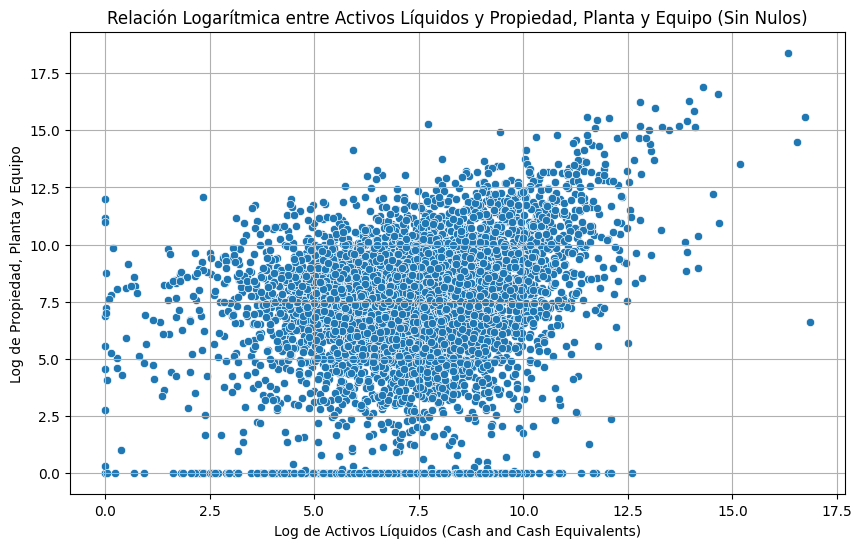

In [68]:
# Eliminar datos nulos antes de aplicar la transformación logarítmica
filtered_df_clean = datos.dropna(subset=['Cash and Cash Equivalents', 'Property, plant and equipment'])

# Aplicar la transformación logarítmica
filtered_df_clean['log_Cash_and_Cash_Equivalents'] = np.log(filtered_df_clean['Cash and Cash Equivalents'] + 1)
filtered_df_clean['log_Property_plant_and_equipment'] = np.log(filtered_df_clean['Property, plant and equipment'] + 1)

# Crear un gráfico de dispersión con los datos reescalados y sin nulos
plt.figure(figsize=(10,6))
sns.scatterplot(data=filtered_df_clean, x='log_Cash_and_Cash_Equivalents', y='log_Property_plant_and_equipment')
plt.title('Relación Logarítmica entre Activos Líquidos y Propiedad, Planta y Equipo (Sin Nulos)')
plt.xlabel('Log de Activos Líquidos (Cash and Cash Equivalents)')
plt.ylabel('Log de Propiedad, Planta y Equipo')
plt.grid(True)
plt.show()


In [70]:
from sklearn.preprocessing import StandardScaler

In [73]:
# Filtrar las columnas numéricas
numeric_columns = datos.select_dtypes(include=['float64', 'int64']).columns
data_numeric = datos[numeric_columns].dropna(axis=1)


# Estandarizar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Aplicar PCA
pca = PCA(n_components=2)  # Escogemos 2 componentes para visualización
pca_result = pca.fit_transform(data_scaled)

# Mostrar la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

In [74]:
explained_variance

array([0.06608201, 0.06008746])

In [87]:
# Filtrar las columnas numéricas
numeric_columns = datos.select_dtypes(include=['float64', 'int64']).columns
data_numeric = datos[numeric_columns].dropna(axis=0)

# Estandarizar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Aplicar PCA para obtener todas las componentes
pca_full = PCA()
pca_full.fit(data_scaled)

# Calcular la varianza acumulada
cumulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Encontrar el número mínimo de componentes que capturan al menos el 60% de la varianza
n_components_60_var = next(i for i, total_var in enumerate(cumulative_variance) if total_var >= 0.60) + 1
print(f"Se necesitan {n_components_60_var} componentes para capturar al menos el 60% de la varianza.")

# Ahora aplicamos PCA con ese número de componentes
pca_final = PCA(n_components=n_components_60_var)
pca_result_final = pca_final.fit_transform(data_scaled)

# Mostrar la varianza explicada por cada componente
explained_variance_final = pca_final.explained_variance_ratio_

# Mostrar la varianza acumulada para el número de componentes necesario
print(f"Varianza explicada acumulada con {n_components_60_var} componentes: {cumulative_variance[n_components_60_var-1]*100:.2f}%")

# Obtener los coeficientes (cargas) de cada componente principal
components = pca_final.components_

# Convertir la matriz de componentes a un DataFrame para una mejor visualización
components_df = pd.DataFrame(components, columns=numeric_columns)

Se necesitan 13 componentes para capturar al menos el 60% de la varianza.
Varianza explicada acumulada con 13 componentes: 63.06%


In [88]:
components_df

,"Property, plant and equipment",Cash and Cash Equivalents,Net Sales Revenue Trend (%),Operating Profit Trend (%),Export_CN,Import_CN,Export_US,Import_US,Export_EC,Import_EC,...,Export_DE,Import_DE,Export_BR,Import_BR,Export_PE,Import_PE,Export_IT,Import_IT,Export_PA,Import_PA
0,0.700269,0.697163,-0.014809,-0.004755,0.050972,-0.010518,0.067920,0.097407,-0.009874,0.000732,...,-0.001845,-0.002128,0.005478,0.011645,0.007582,-0.009825,-0.004380,-0.013643,0.074856,0.006875
1,0.042611,0.034790,0.004032,-0.033205,0.252839,0.525773,-0.381151,-0.452895,0.150175,-0.061976,...,-0.327215,-0.300530,-0.155163,0.025433,0.125056,0.087203,0.026297,-0.056502,0.130315,0.012067
2,0.009124,-0.002951,-0.135302,-0.068030,0.095830,0.223221,-0.177237,-0.092764,0.349170,-0.032046,...,0.477871,0.597456,0.061276,0.147547,0.200440,0.009250,0.125938,0.141724,0.202131,0.021286
3,-0.043435,-0.054796,-0.137597,-0.075138,0.073537,0.212149,0.211726,0.381927,0.261466,0.032416,...,-0.200779,-0.152451,0.169265,0.213981,0.231560,0.031136,-0.237731,-0.269181,0.004984,-0.008263
4,-0.002220,-0.010435,-0.178478,-0.084819,-0.013325,0.003147,0.175528,0.052868,0.184573,0.232897,...,-0.268046,-0.180513,0.126464,0.164968,0.030715,-0.025753,0.525885,0.548862,-0.065685,-0.040772
5,-0.024097,-0.033318,-0.359412,-0.349575,0.047527,-0.049447,0.063118,0.072713,0.069798,0.114505,...,-0.016733,-0.022453,0.200432,0.287455,-0.013973,0.068966,-0.280616,-0.208572,0.187546,0.147873
6,0.012776,0.021220,0.254941,0.253368,0.117405,-0.110800,-0.053424,-0.007169,0.125951,0.278048,...,0.046765,-0.004023,0.282938,0.400667,0.135939,0.209547,0.071553,0.024561,-0.250911,-0.192783
7,0.018556,0.017034,0.348802,0.410864,-0.036148,-0.059010,-0.148520,-0.075918,0.124031,-0.054202,...,-0.038437,0.014464,0.178668,0.185774,0.083531,0.028740,-0.189806,-0.157181,-0.106018,-0.086523
8,-0.036342,-0.060959,0.293991,0.334991,0.215519,0.175515,0.285479,0.096419,0.059622,0.108788,...,-0.022400,0.015726,-0.001807,0.114826,-0.286354,-0.314352,0.068465,0.016565,0.432321,0.458607
9,-0.005283,0.001142,-0.112932,-0.095466,0.487940,0.132738,0.079138,-0.058478,-0.041377,-0.070768,...,0.155983,-0.008745,0.036628,0.120659,-0.372604,-0.480670,-0.006239,-0.093585,-0.345093,-0.397851


In [89]:
components_df.to_csv("datos/componentes.csv")